In [25]:
import json, os, itertools
import numpy as np
import pandas as pd
import os, time, datetime, pickle

from __future__ import print_function
import numpy as np
np.random.seed(1337)  # for reproducibility

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding
from keras.layers import LSTM
from keras.layers import Convolution1D, MaxPooling1D


from sklearn.metrics import confusion_matrix
import matplotlib.pylab as plt

%matplotlib inline

### Data Loading

In [2]:
# Data Preparation
# ==================================================
# Loads x/y from pickle, assumes pre-shuffled
datapath = './mapped_data/'
datafiles = [f for f in os.listdir(datapath) if '.pkl' in f]
filename = datafiles[0]
with open(datapath + filename, 'r') as f:
    dataset = pickle.load(f)
    x_shuffled = dataset['x']
    y_shuffled = dataset['y']


# Split train/test set
split_sample_index = -1 * int(.1 * float(len(y_shuffled)))
X_train, X_test = x_shuffled[:split_sample_index], x_shuffled[split_sample_index:]
y_train, y_test = y_shuffled[:split_sample_index], y_shuffled[split_sample_index:]

In [3]:
print(X_train.shape)

(540000, 71)


### Example input data and label

In [ ]:
#Example of input data
example = x_shuffled[0]
print(example.shape)
print(example)
print(y_shuffled[0])

(71,)
[   290    290   9294   5976    374 115081   6093 110179   2146 113007
 110594    290   1978 113376 110693      9      9      9      9      9
      9      9      9      9      9      9      9      9      9      9
      9      9      9      9      9      9      9      9      9      9
      9      9      9      9      9      9      9      9      9      9
      9      9      9      9      9      9      9      9      9      9
      9      9      9      9      9      9      9      9      9      9
      9]
[0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


### Model Creation

In [ ]:
# Embedding
max_features = np.max(x_shuffled)
maxlen = max([len(t) for t in x_shuffled])
embedding_size = 128

# Convolution
filter_length = 5
nb_filter = 64
pool_length = 4

# LSTM
lstm_output_size = 70

# Training
batch_size = 30
nb_epoch = 1

#For user in final fully connected layer
classes = len(y_shuffled[0]) 

model = Sequential()
model.add(Embedding(max_features, embedding_size, input_length=maxlen))
model.add(Dropout(0.25))
model.add(Convolution1D(nb_filter=nb_filter,
                        filter_length=filter_length,
                        border_mode='valid',
                        activation='relu',
                        subsample_length=1))
model.add(MaxPooling1D(pool_length=pool_length))
model.add(LSTM(lstm_output_size))
model.add(Dense(classes))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print('Train...')
model.fit(X_train, y_train, batch_size=batch_size, nb_epoch=nb_epoch,
          validation_data=(X_test, y_test))
score, acc = model.evaluate(X_test, y_test, batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

Train...
Train on 540000 samples, validate on 60000 samples
Epoch 1/1
222390/540000 [===========>..................] - ETA: 2552s - loss: 0.0220 - acc: 0.9943

In [6]:
model.evaluate(X_test, y_test)

60000/60000 [==============================] - 23s    


[0.0032406840410122337, 0.99912301915486657]

In [7]:
model.save_weights('./misc/cnn_lstm_20170131.h5')

## Load Startup.ML Test Set

In [8]:
with open('./misc/startup_test_set.pkl', 'r') as f:
    dataset = pickle.load(f)
    x_startup = dataset['x']
    y_startup = dataset['y']


In [9]:
model.evaluate(x_startup, y_startup)

21000/21000 [==============================] - 8s     


[0.0078778330333242642, 0.99777551396687825]

In [10]:
preds = model.predict(x_startup)

In [14]:
act_label = np.argmax(y_startup, axis=1)
pred_label = np.argmax(preds, axis=1)

In [17]:
df = pd.DataFrame({'actual': act_label, 'predicted':pred_label})


In [35]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=14)
    plt.yticks(tick_marks, classes, fontsize=14)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", fontsize=12)

    plt.tight_layout()
    plt.ylabel('True label', fontsize=16)
    plt.xlabel('Predicted label', fontsize=16)

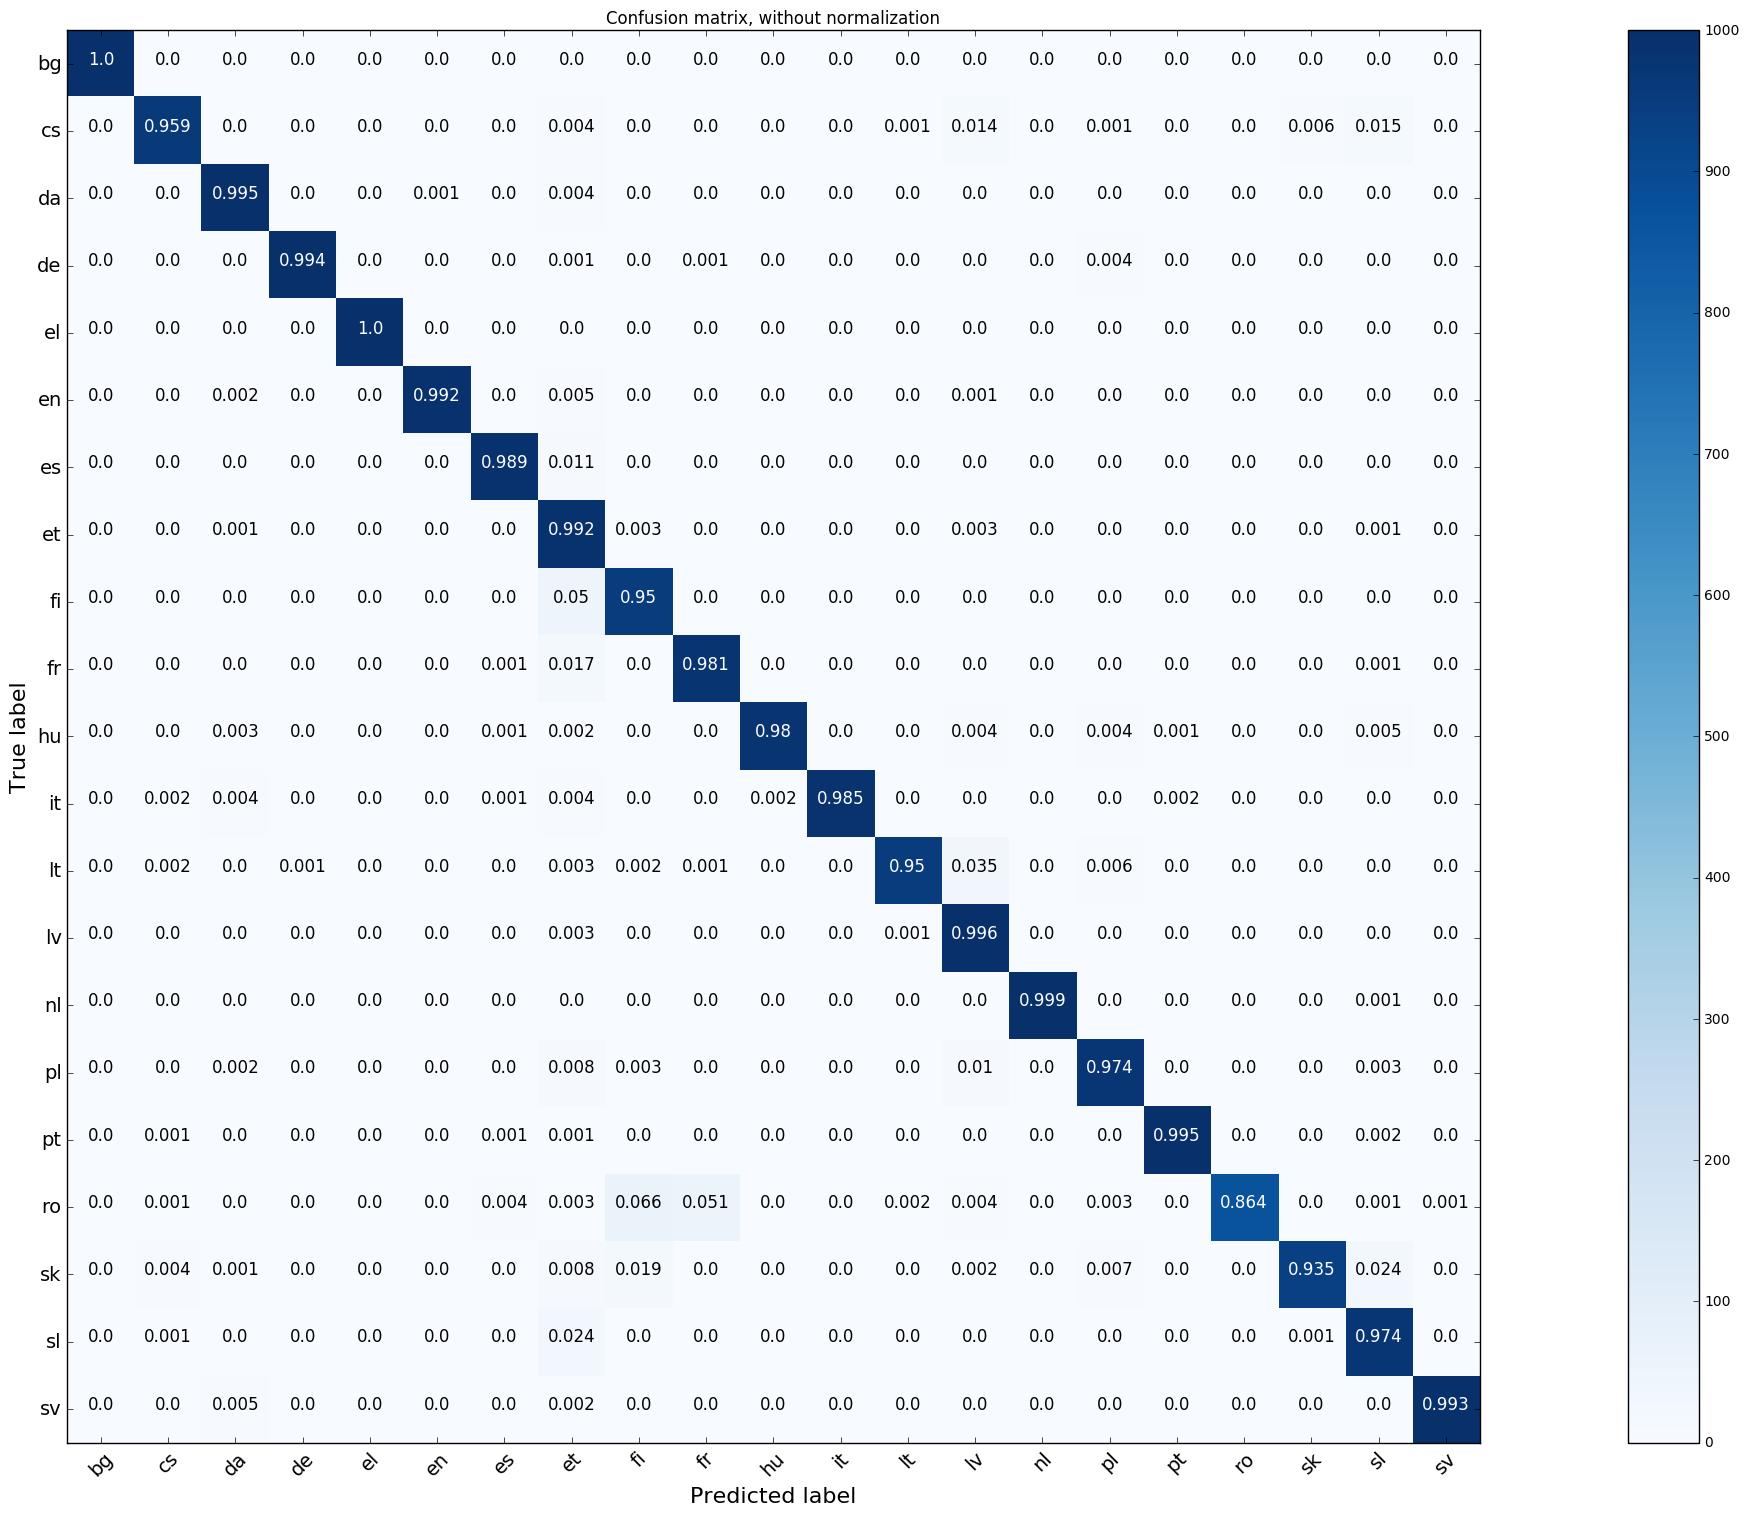

In [38]:
classnames =['bg', 'cs', 'da', 'de', 'el', 'en', 'es', 'et', 'fi', 'fr', 'hu', 'it',
            'lt', 'lv', 'nl', 'pl', 'pt', 'ro', 'sk', 'sl', 'sv']

cnf_matrix = confusion_matrix(act_label, pred_label)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
fig = plt.figure(figsize=(30,15))
plot_confusion_matrix(cnf_matrix, classes=classnames, normalize=True,
                      title='Confusion matrix, without normalization')

plt.show()
fig.savefig('./misc/conf_matrix.png', dpi=300)